In [1]:
import sys

from protocol.connection_elements.error_correction.FiveQubitCorrection import FiveQubitEncoder, FiveQubitDecoder

sys.path.append("..")


from experiments.plt_pab_fae import plt_fab_fae
from protocol.BB84EveTrainableProtocol import BB84EveTrainableProtocol
from protocol.BB84TrainableProtocol import BB84TrainableProtocol
from protocol.BB84Protocol import BB84Protocol
from protocol.connection_elements.MultiQubitQCLEve import MultiQubitQCLEve
from protocol.connection_elements.error_correction.ThreeQubitCorrection import ThreeQubitBitFlipEncoder, ThreeQubitBitFlipDecoder



No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
/home/wpalka/.virtualenvs/BB84-QCL-error-correction/lib/python3.12/site-packages/qiskit/circuit/quantumcircuit.py:3428: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


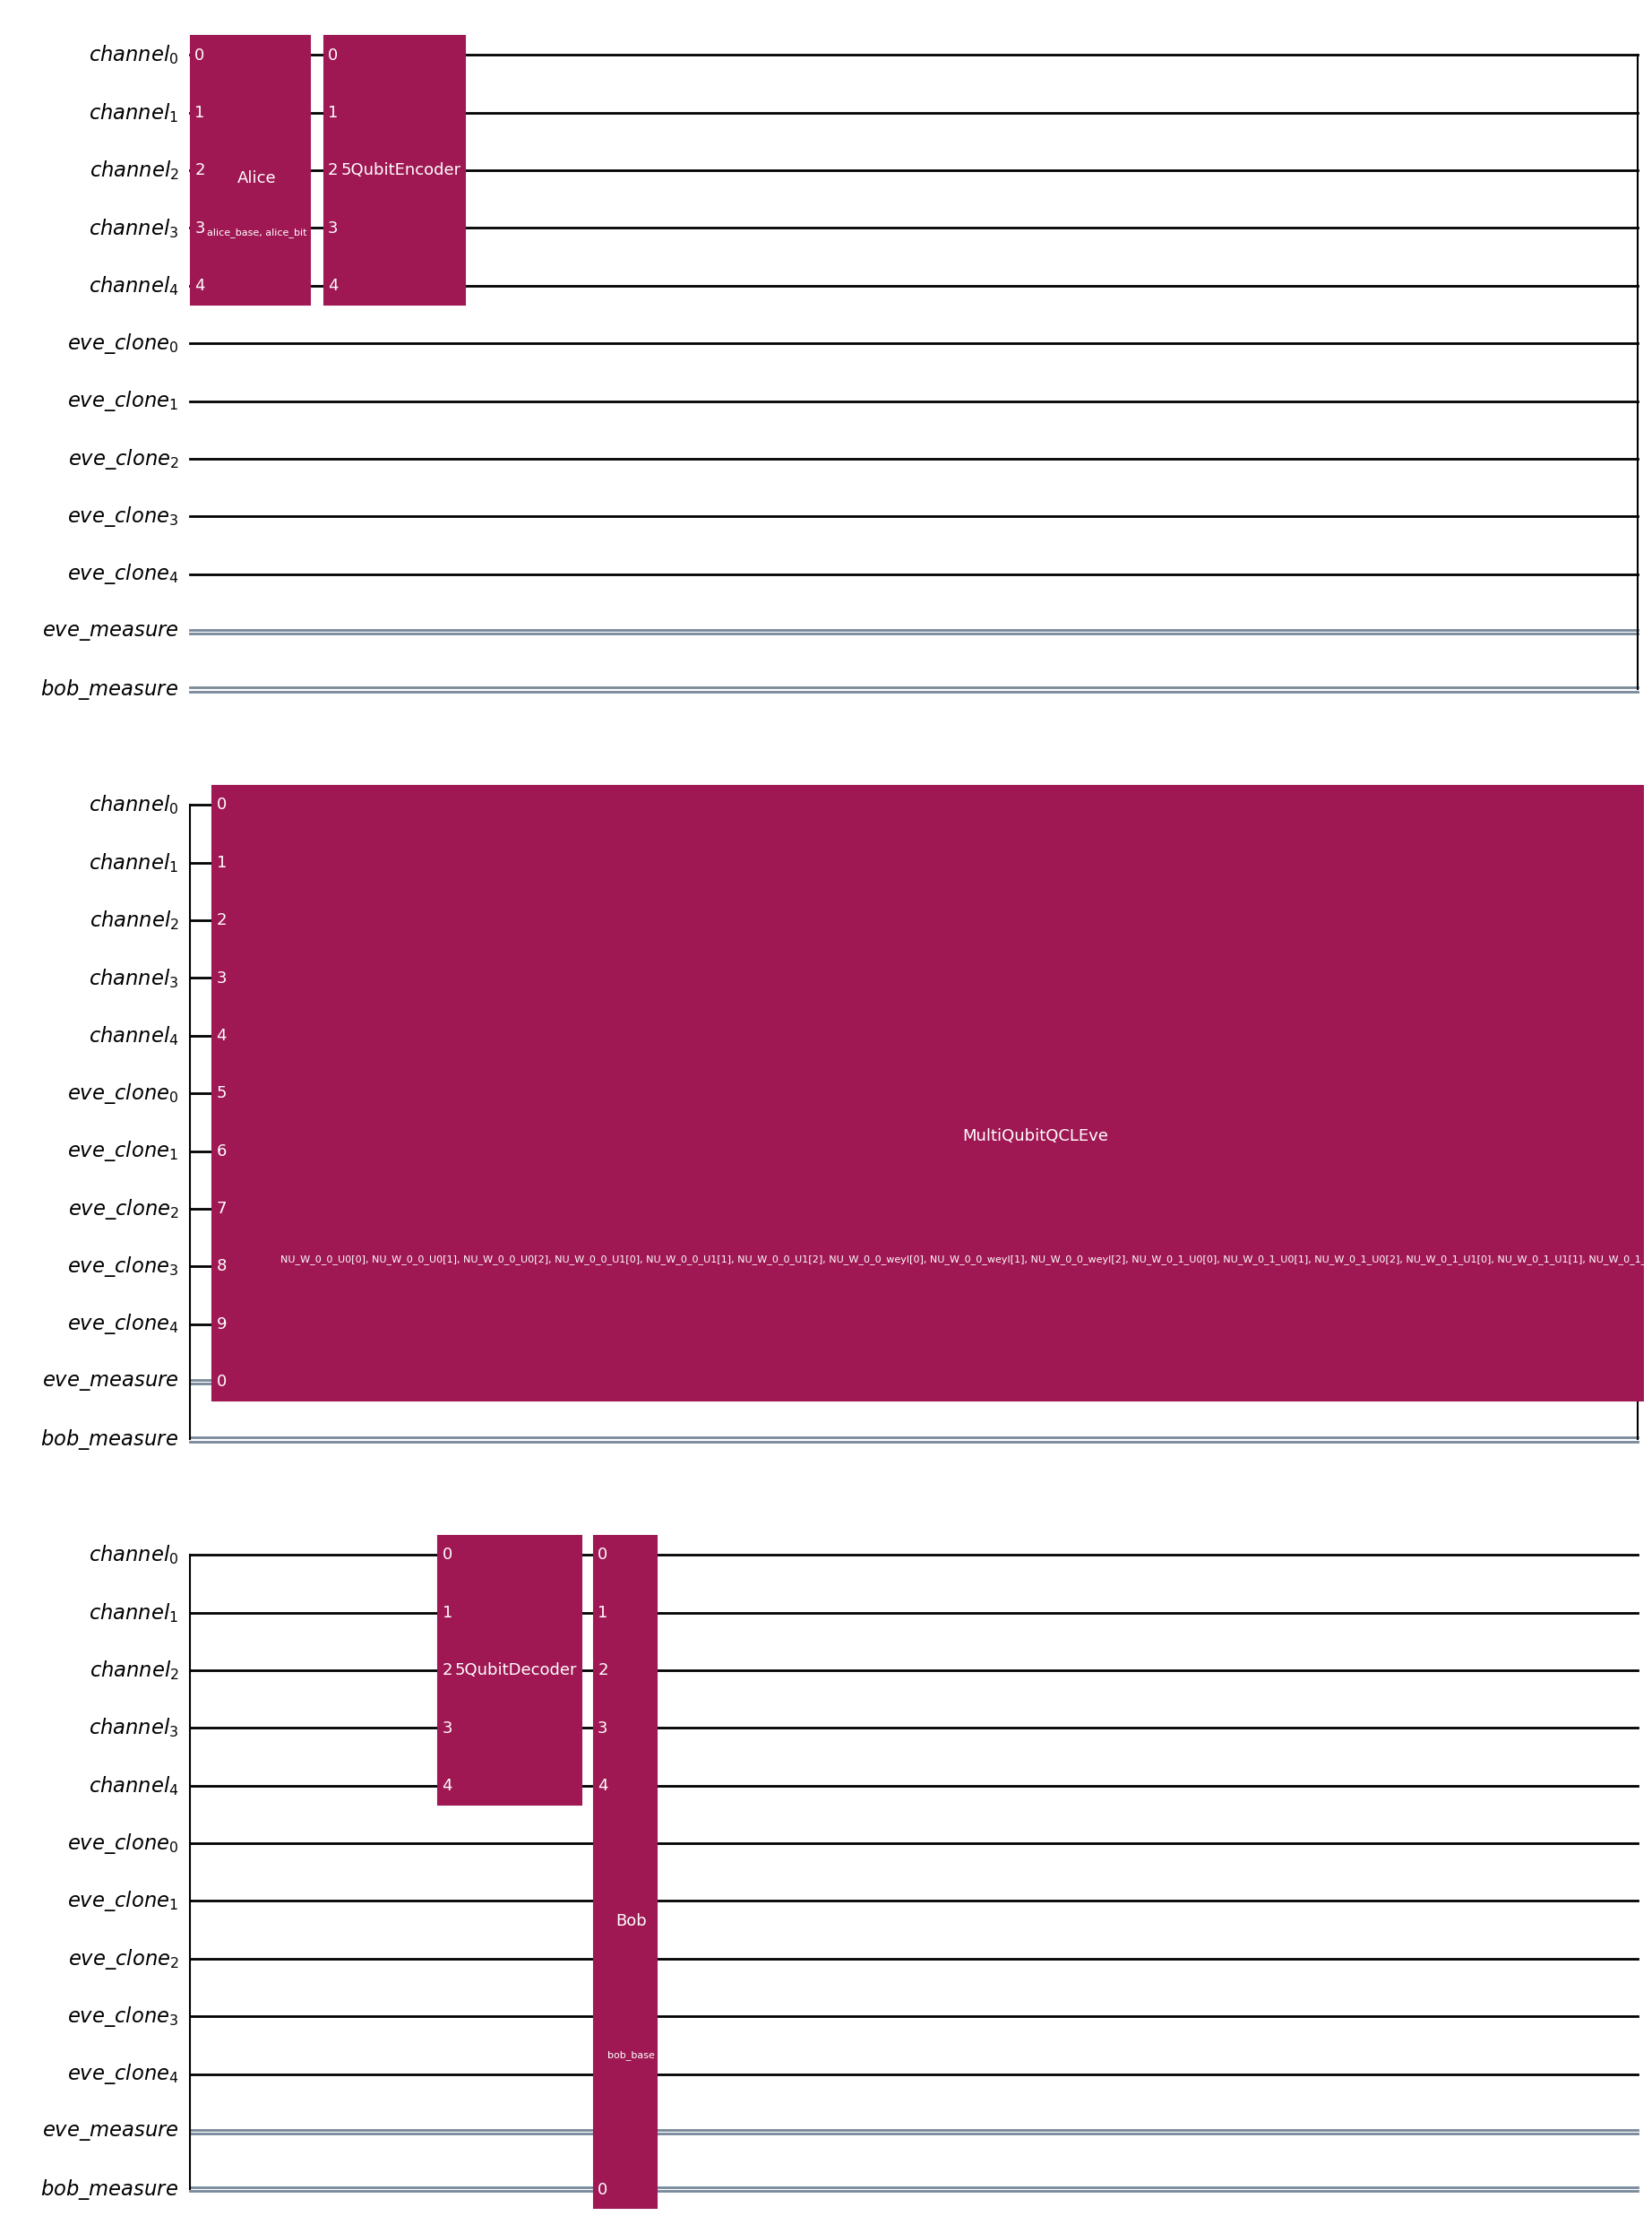

In [2]:
layers = [FiveQubitEncoder(), FiveQubitDecoder()]
eve = MultiQubitQCLEve()

eve_protocol = BB84EveTrainableProtocol(n_bits=512, elements=[layers[0], eve, layers[1]], channel_size=5,
                                        seed=0, alpha=1, learning_rate=0.05)

qc, _ = eve_protocol.qc_with_ctx()
qc.draw("mpl", expr_len=3)

In [3]:
def train_eve():
    bob_qber, eve_qber = [], []
    qber = eve_protocol.run()
    bob_qber.append(qber['bob_qber'])
    eve_qber.append(qber['eve_qber'])
    print(f'start QBER: {qber}')
    for epoch in range(50):
        loss = eve_protocol.train()
        qber = eve_protocol.run()
        bob_qber.append(qber['bob_qber'])
        eve_qber.append(qber['eve_qber'])
        if epoch % 5 == 0 or epoch == 49:
            print(f'epoch: {epoch}, loss: {loss}, QBER: {qber}')
    return bob_qber, eve_qber

{'bob_qber': np.float64(0.0)}


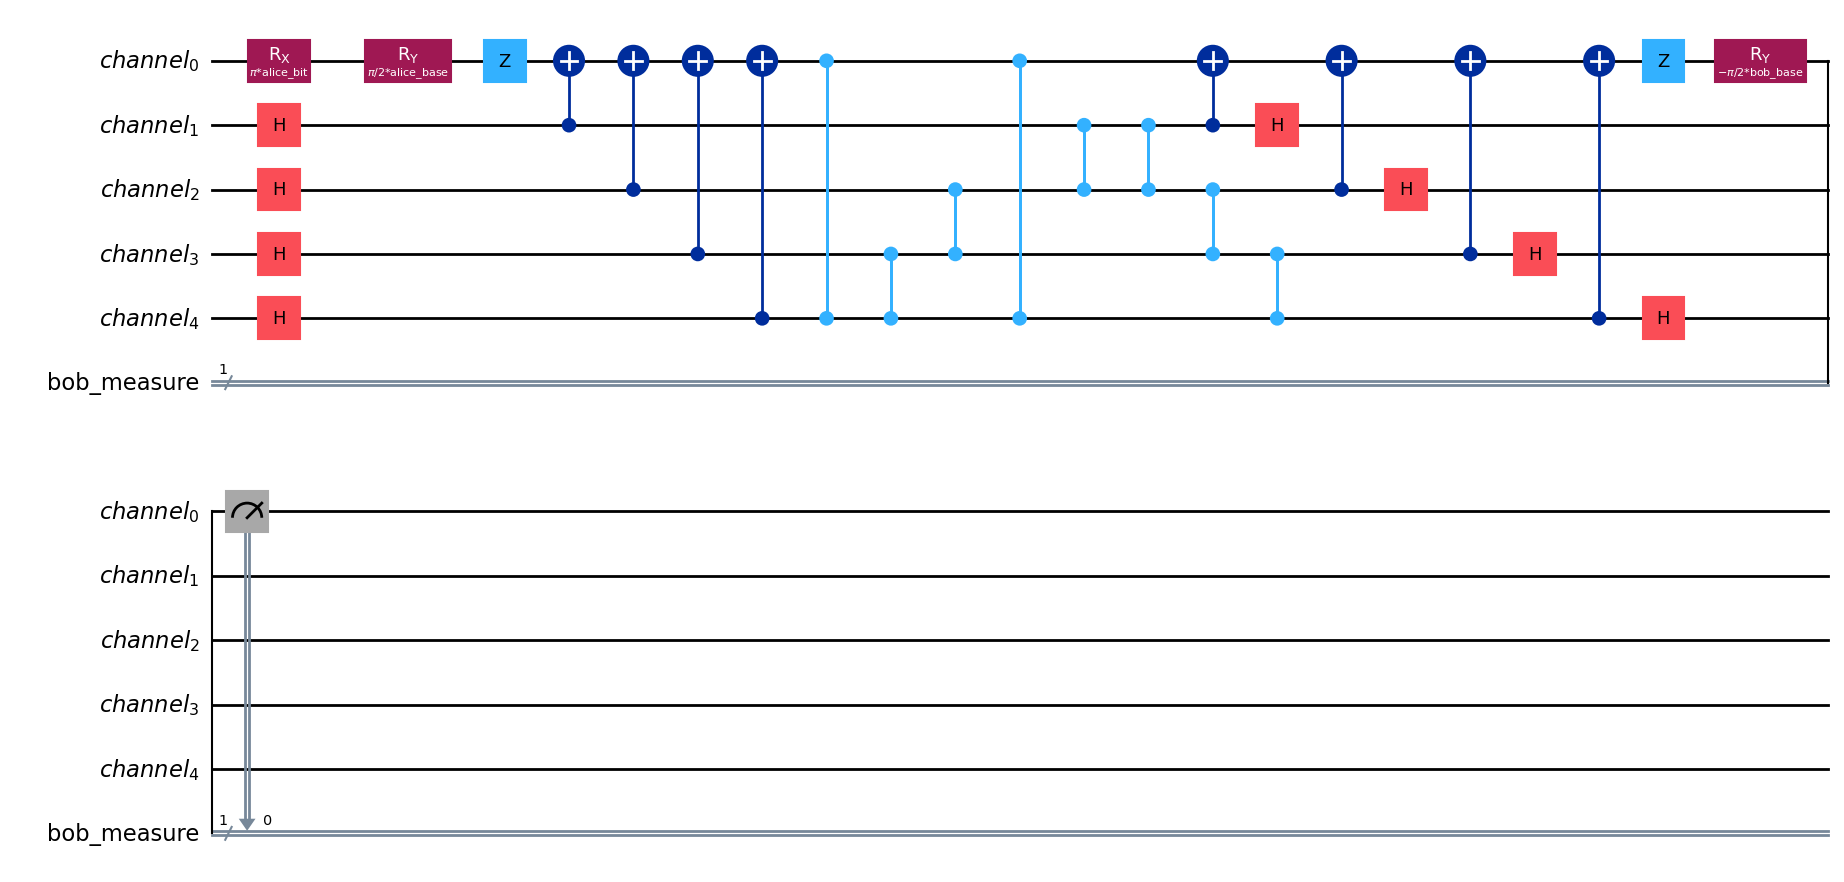

In [4]:
protocol = BB84Protocol(512, layers, channel_size=5, seed=0)
print(protocol.run())

protocol.qc_with_ctx()[0].decompose().draw("mpl")

# Krok 2 - trenowanie tylko Eve, warstwy Alice i Boba zamrożone
Uczymy samą Eve, docelowa dokładność Boba to 0.8. Startujemy od parametrów Alice i Boba wytrenowanych w poprzednim kroku i Eve jako identyczność.

In [5]:
params = eve_protocol.get_all_parameters()
for p in eve.trainable_parameters():
    k = p.name
    params[k] = 0

eve_protocol.set_parameters(params)


No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
/home/wpalka/.virtualenvs/BB84-QCL-error-correction/lib/python3.12/site-packages/qiskit_machine_learning/connectors/torch_connector.py:378: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights.data = torch.tensor(initial_weights, dtype=torch.float)


In [6]:
eve_protocol.f_value = 0.8
b_q, e_q = train_eve()

start QBER: {'bob_qber': np.float64(0.0), 'eve_qber': np.float64(0.5294117647058824)}



KeyboardInterrupt



In [ ]:
plt_fab_fae(b_q, e_q, 0.8)

In [ ]:
print("All parameters:", eve_protocol.get_all_parameters())

In [ ]:
eve_protocol._qc.assign_parameters(eve_protocol.get_all_parameters()).draw("mpl")